In [1]:
import sqlite3
import pandas
database_name = "/home/becode/Downloads/Documents/churn_prediction/data/database.db"
conn = sqlite3.connect(database_name)
df = pandas.read_sql('SELECT Attrition_Flag, Total_Relationship_Count, Credit_Limit, Total_Revolving_Bal, Avg_Open_To_Buy, Total_Trans_Amt, Total_Trans_Ct FROM bank_churners', conn)
#df = df[['Customer_Age', 'Gender', 'Dependent_count', 'Education_Level', 'Marital_Status', 'Income_Category', 'Card_Category', 'Months_on_book']]
print(df.head())
conn.close()

      Attrition_Flag  Total_Relationship_Count  Credit_Limit  \
0  Existing Customer                         5       12691.0   
1  Existing Customer                         6        8256.0   
2  Existing Customer                         4        3418.0   
3  Existing Customer                         3        3313.0   
4  Existing Customer                         5        4716.0   

   Total_Revolving_Bal  Avg_Open_To_Buy  Total_Trans_Amt  Total_Trans_Ct  
0                  777          11914.0             1144              42  
1                  864           7392.0             1291              33  
2                    0           3418.0             1887              20  
3                 2517            796.0             1171              20  
4                    0           4716.0              816              28  


In [2]:
df.dtypes

Attrition_Flag               object
Total_Relationship_Count      int64
Credit_Limit                float64
Total_Revolving_Bal           int64
Avg_Open_To_Buy             float64
Total_Trans_Amt               int64
Total_Trans_Ct                int64
dtype: object

In [4]:
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
numeric_features = df.select_dtypes(include=['float64', 'int64'])
categorical_features = df.select_dtypes(include=['object'])
lb = LabelEncoder()
for var in categorical_features:
    df[var] = lb.fit_transform(df[var])
#X = df.drop(['CLIENTNUM','Attrition_Flag','Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1','Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2'], axis = 1)
X = df.drop('Attrition_Flag', axis=1)
y = df['Attrition_Flag']


In [7]:
from sklearn.model_selection import GridSearchCV

n_components = [4,6,8,9,10]
criterion = ['gini', 'entropy', 'log_loss']
max_depth = [4,6,8,9,10]
# Create a parameter gridrandom_state=1
params = {
    'max_leaf_nodes':n_components,
    'criterion':criterion,
    'max_depth':max_depth}

# Initialize the grid search object
grid_search = GridSearchCV(DecisionTreeClassifier(random_state=1), param_grid=params)

In [8]:
grid_search.fit(X, y)

GridSearchCV(estimator=DecisionTreeClassifier(random_state=1),
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_depth': [4, 6, 8, 9, 10],
                         'max_leaf_nodes': [4, 6, 8, 9, 10]})

In [9]:
print(grid_search.best_params_)   

{'criterion': 'entropy', 'max_depth': 4, 'max_leaf_nodes': 6}


In [10]:
X.columns

Index(['Total_Relationship_Count', 'Credit_Limit', 'Total_Revolving_Bal',
       'Avg_Open_To_Buy', 'Total_Trans_Amt', 'Total_Trans_Ct'],
      dtype='object')

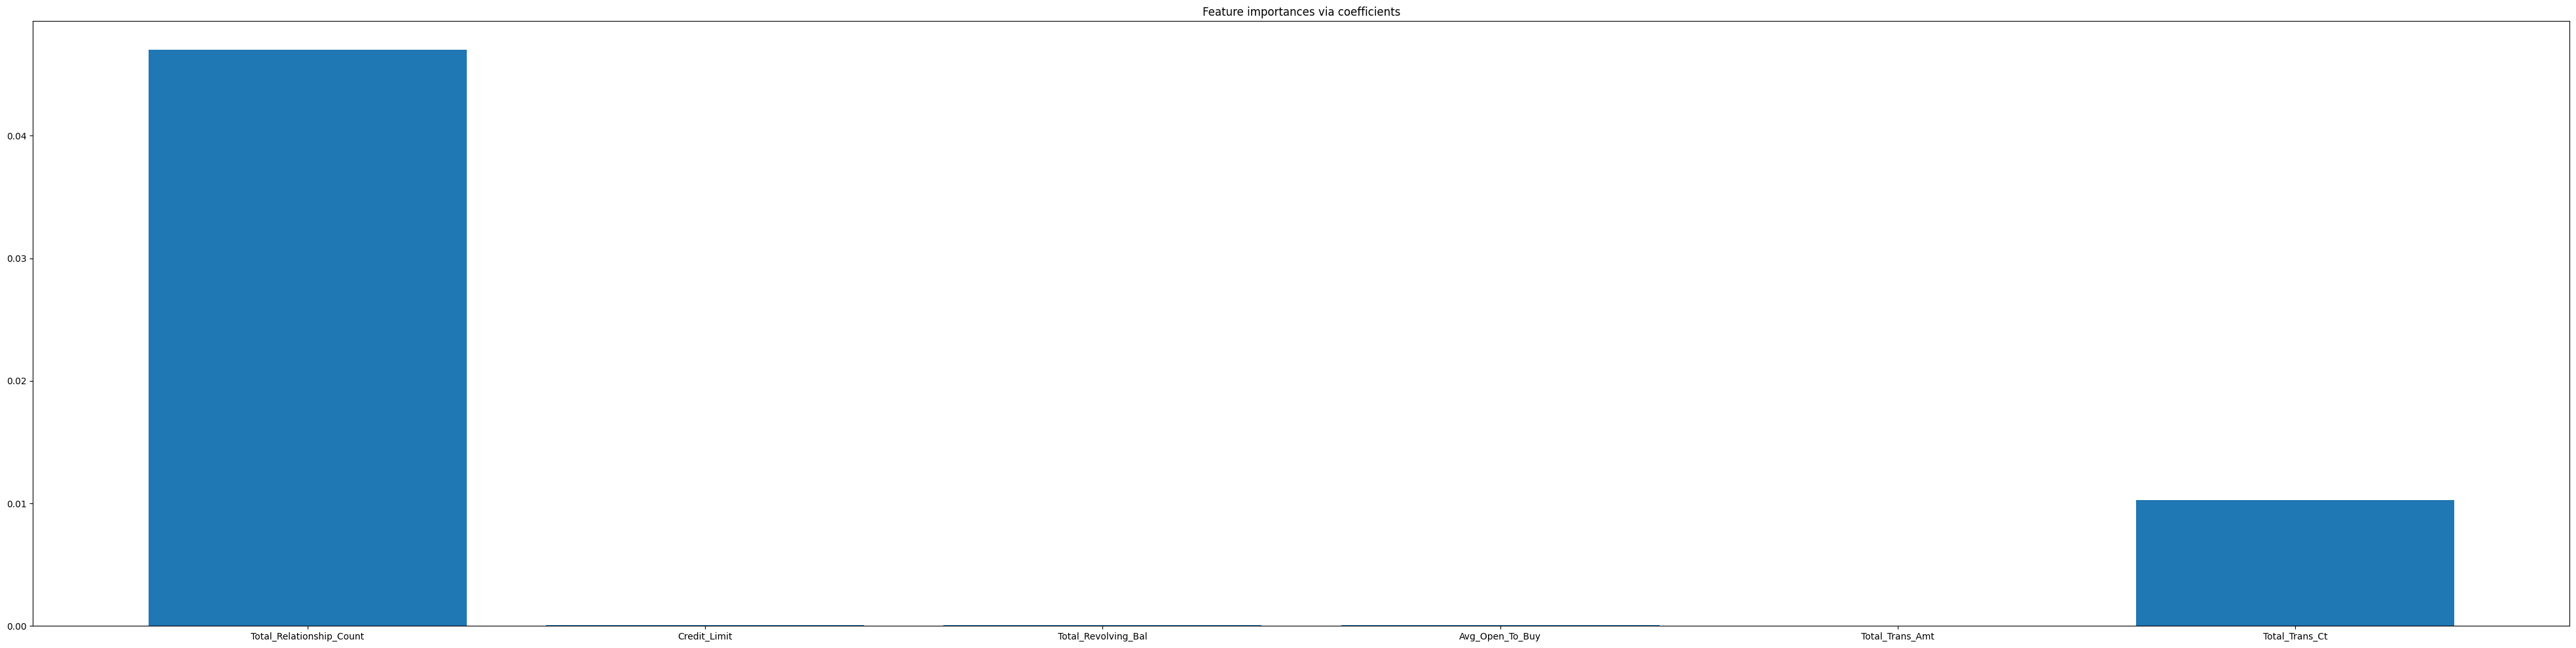

In [11]:
from matplotlib import pyplot as plt
import numpy as np
from sklearn.linear_model import RidgeCV

ridge = RidgeCV(alphas=np.logspace(-6, 6, num=5)).fit(X, y)
importance = np.abs(ridge.coef_)
feature_names = np.array(X.columns)
fig = plt.figure(figsize=(50, 12))
plt.bar( height=importance, x=feature_names)
plt.title("Feature importances via coefficients")
plt.show()

In [12]:
from sklearn.model_selection import train_test_split


SEED = 1
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, shuffle = False, random_state = 0)
# Instantiate dt_entropy, set 'entropy' as the information criterion
dt_entropy = DecisionTreeClassifier(max_depth=8, criterion='entropy', random_state=1)
# Fit dt_entropy to the training set
dt_entropy.fit(X_train, y_train)
# Predict test set labels
y_pred = dt_entropy.predict(X_test)

In [13]:
# Import DecisionTreeRegressor from sklearn.tree
from sklearn.tree import DecisionTreeRegressor
# Instantiate dt
dt = DecisionTreeRegressor(max_depth=8,min_samples_leaf=0.13,random_state=3)
# Fit dt to the training set
dt.fit(X_test, y_test)

DecisionTreeRegressor(max_depth=8, min_samples_leaf=0.13, random_state=3)

In [14]:
SEED = 1
from sklearn.impute import KNNImputer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeRegressor
lr = LogisticRegression(solver='lbfgs', max_iter=300, random_state=SEED)
# Instantiate a DecisionTreeRegressor dt
dr = DecisionTreeRegressor(max_depth=4, min_samples_leaf=0.26, random_state=SEED)
# Instantiate dt
dt = DecisionTreeClassifier(min_samples_leaf=0.13, random_state=SEED)
# Define the list classifiers
classifiers = [('Logistic Regression', lr), ('DecisionTreeRegressor', dr), ('Classification Tree', dt)]

In [15]:
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score
classifiers = [('Logistic Regression', lr), ('Classification Tree', dt)]
# Instantiate a VotingClassifier vc
vc = VotingClassifier(estimators=classifiers)     
# Fit vc to the training set
vc.fit(X_train, y_train)   
# Evaluate the test set predictions
y_pred = vc.predict(X_test)
# Calculate accuracy score
accuracy = accuracy_score(y_test, y_pred)
print('Voting Classifier: {:.3f}'.format(accuracy))

Voting Classifier: 0.862


In [16]:
# Import BaggingClassifier
from sklearn.ensemble import BaggingClassifier
# Instantiate bc
bc = BaggingClassifier(estimator=dt, n_estimators=50, oob_score=True, random_state=1)
# Fit bc to the training set
bc.fit(X_train, y_train)
# Predict test set labels
y_pred = bc.predict(X_test)
# Evaluate acc_test
acc_test = accuracy_score(y_test, y_pred)
print('Test set accuracy of bc: {:.2f}'.format(acc_test)) 

Test set accuracy of bc: 0.80


In [17]:
# Import AdaBoostClassifier
from sklearn.ensemble import AdaBoostClassifier
ada = AdaBoostClassifier(estimator=dt, n_estimators=180, random_state=1)
ada.fit(X_train, y_train)
# Compute the probabilities of obtaining the positive class
y_pred_proba = ada.predict_proba(X_test)[:,1]
# Import roc_auc_score
from sklearn.metrics import roc_auc_score
# Evaluate test-set roc_auc_score
ada_roc_auc = roc_auc_score(y_test, y_pred_proba)
# Print roc_auc_score
print('ROC AUC score: {:.2f}'.format(ada_roc_auc))

ROC AUC score: 0.88


In [18]:
from sklearn.ensemble import GradientBoostingRegressor

# Instantiate gb
gb = GradientBoostingRegressor(max_depth=4,subsample=0.9,
            max_features=0.75,n_estimators=200,random_state=2)
# Fit gb to the training set
gb.fit(X_train, y_train)
# Predict test set labels
y_pred = gb.predict(X_test)
# Import mean_squared_error as MSE
from sklearn.metrics import mean_squared_error as MSE
# Compute MSE
mse_test = MSE(y_test, y_pred)
# Compute RMSE
rmse_test = mse_test **(1/2)
# Print RMSE
print('Test set RMSE of gb: {:.3f}'.format(rmse_test))

Test set RMSE of gb: 0.400


In [19]:
params_dt = {'max_depth': [2, 3, 4], 'min_samples_leaf':[0.12, 0.14, 0.16, 0.18]}

In [20]:
from sklearn.model_selection import GridSearchCV
grid_dt = GridSearchCV(estimator=dt,param_grid=params_dt,scoring='roc_auc',cv=5,n_jobs=-1)
grid_dt.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=DecisionTreeClassifier(min_samples_leaf=0.13,
                                              random_state=1),
             n_jobs=-1,
             param_grid={'max_depth': [2, 3, 4],
                         'min_samples_leaf': [0.12, 0.14, 0.16, 0.18]},
             scoring='roc_auc')

In [21]:
from sklearn.metrics import roc_auc_score
# Extract the best estimator
best_model = grid_dt.best_estimator_
# Predict the test set probabilities of the positive class
y_pred_proba = best_model.predict_proba(X_test)[:,1]
# Compute test_roc_auc
test_roc_auc = roc_auc_score(y_test,y_pred_proba)
# Print test_roc_auc
print('Test set ROC AUC score: {:.3f}'.format(test_roc_auc))

Test set ROC AUC score: 0.783


In [22]:
from sklearn.ensemble import RandomForestClassifier

param_grid = {'n_estimators': range(10, 50, 10)}

# Optimize for a RandomForestClassifier() using GridSearchCV
grid = GridSearchCV(RandomForestClassifier(), param_grid, cv=3)
grid.fit(X, y)
grid.best_params_

{'n_estimators': 20}

In [23]:
# Function computing absolute difference from column mean
from sklearn.feature_selection import SelectKBest, chi2

def abs_diff(x):
    return abs(x- np.mean(x))

# Apply it to the credit amount and store to new column
X['Credit_Limit_diff'] = abs_diff(X['Credit_Limit'])

# Create a feature selector with chi2 that picks one featureIncome_Category
sk = SelectKBest(chi2, k = 1)

# Use the selector to pick between credit_amount and diff
#sk.fit(X[['Education_Level', 'Education_Level_diff']], y)
sk.fit(X[['Credit_Limit', 'Credit_Limit_diff']], y)

# Inspect the results
sk.get_support()

array([ True, False])

In [24]:
rfc = RandomForestClassifier
grid_search = GridSearchCV(rfc(random_state=1), param_grid={'max_depth':[2,5,10]})
best_value = grid_search.fit(X_train, y_train).best_params_['max_depth']

# Using the best value from above, fit a random forest
clf = rfc(random_state=1, max_depth=best_value).fit(X_train, y_train)

# Apply SelectKBest with chi2 and pick top 100 features
vt = SelectKBest(chi2, k=6).fit(X_train, y_train)

# Create a new dataset only containing the selected features
X_train_reduced = vt.transform(X_train)


In [25]:
vt.get_feature_names_out()

array(['Total_Relationship_Count', 'Credit_Limit', 'Total_Revolving_Bal',
       'Avg_Open_To_Buy', 'Total_Trans_Amt', 'Total_Trans_Ct'],
      dtype=object)

In [26]:
type(X_test)

pandas.core.frame.DataFrame